# Time-series models

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy
import matplotlib.ticker as ticker

# Homework 1: Using ARIMA model to predict food_retail capital in Australia.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')

## Task 1. Sum up the yearly capital of food retailing and visualize the timeline.


In [3]:
#Sum up the yearly capital of food retailing
df['year']=pd.to_datetime(df['month']).dt.strftime("%Y")
task1=df.groupby(by='year').sum()
task1=pd.DataFrame(task1['food_retailing'])
task1

,food_retailing
year,
1982,147.8
1983,218.0
1984,240.6
1985,273.1
1986,303.3
1987,353.0
1988,363.2
1989,402.8
1990,464.1


<AxesSubplot:xlabel='year'>

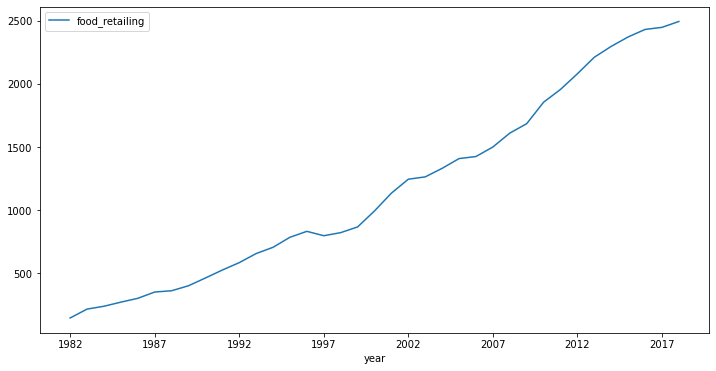

In [4]:
#visualize the timeline
task1.plot(figsize=(12,6))

<AxesSubplot:xlabel='year'>

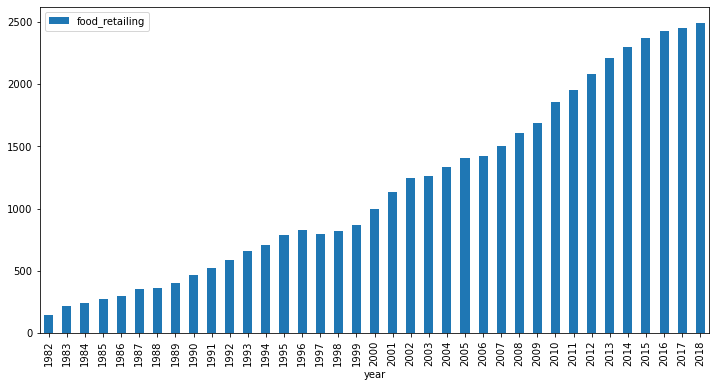

In [5]:
task1.plot.bar(figsize=(12,6))

## Task 2. Us3 the adfuller tool to determine if the time series is stationary or not, $\alpha=0.05$. If not, find a proper order of differencing (d) in the ARIMA model to reach the stationarity, and report adfuller test results after differencing.


In [6]:
#Use the adfuller tool to determine if the time series is stationary or not
from statsmodels.tsa.stattools import adfuller
print('raw series')
result = adfuller(task1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('1st order differencing')
result = adfuller(task1.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# second order differencing

print('2st order differencing')
result = adfuller(task1.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


raw series
ADF Statistic: 2.548309
p-value: 0.999064
1st order differencing
ADF Statistic: -3.444382
p-value: 0.009536
2st order differencing
ADF Statistic: -2.936616
p-value: 0.041253


As we can see, raw seires p-value is 0.999064. we can't reject the null hypothesis, the time-series might not be stationary. 1st order differencing seires p-value is 0.009536. we accept reject the null hypothesis, the time-series is stationary.2st order differencing seires p-value is  0.041253. we accept reject the null hypothesis, the time-series is stationary.

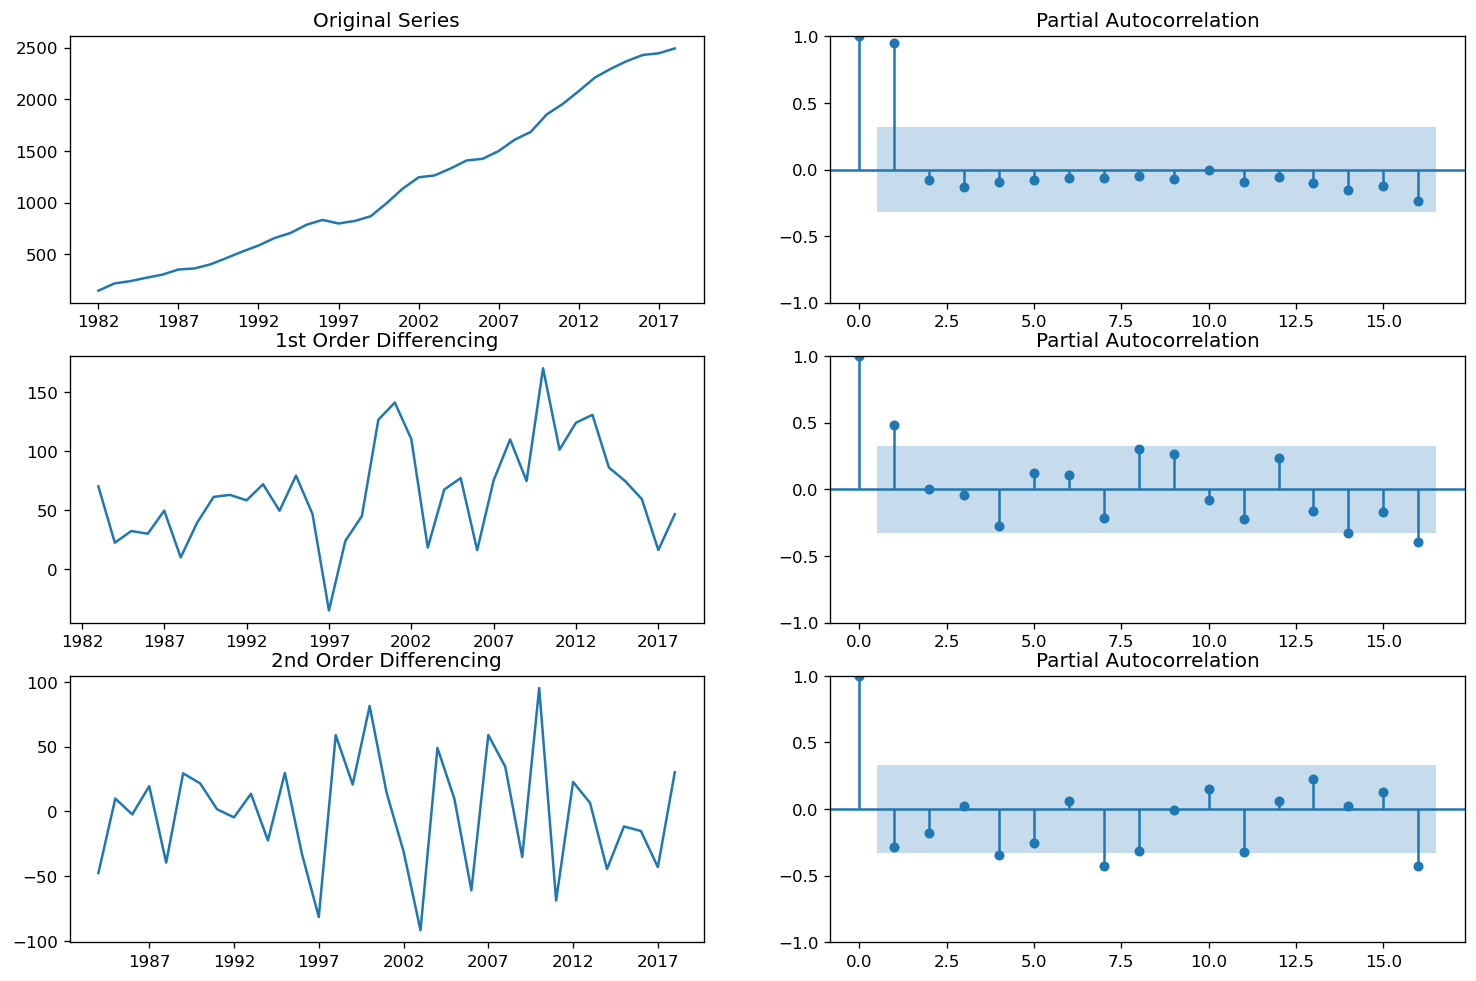

In [7]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(task1.food_retailing); axes[0, 0].set_title('Original Series')
axes[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(5))
plot_pacf(task1.food_retailing, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(task1.food_retailing.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(5))
plot_pacf(task1.food_retailing.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')


# 2nd Differencing
axes[2, 0].plot(task1.food_retailing.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].xaxis.set_major_locator(ticker.MultipleLocator(5))
plot_pacf(task1.food_retailing.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

Dataset is stationary after differenced once. After differecing twice, autocorrelations are all small and patternless, and drop to insignificant area too quick, then the series does not need a higher order of differencing. So we choose d=1

## Task 3. Analyze the PACF and ACF plots to determine appropriate number of AR, MA terms


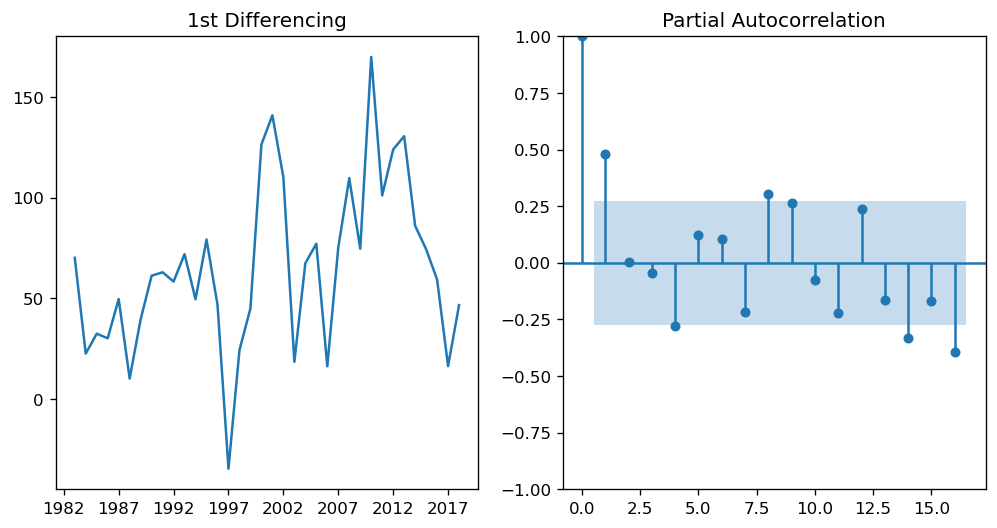

In [8]:
#determine appropriate number of AR
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(task1.food_retailing.diff())
axes[0].set_title('1st Differencing')
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
# axes[1].set_ylim(0,1)
plot_pacf(task1.food_retailing.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

#### We take the order of AR term to be equal to as many lags that cross the significance area in the PACF plot or until a shart drop-off. This likely suggests AR(1).  Thus Q=1

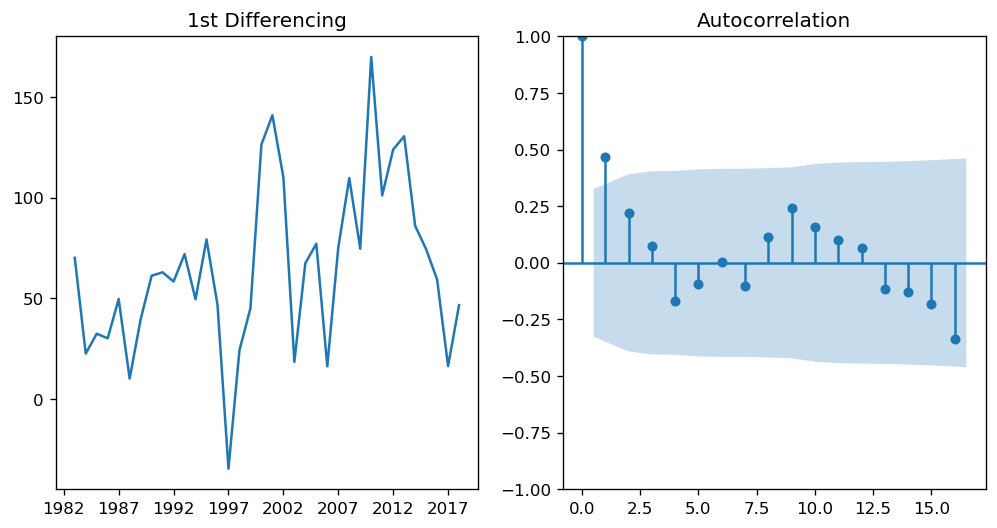

In [9]:
#determine appropriate number of MA
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(task1.food_retailing.diff()); axes[0].set_title('1st Differencing')
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
plot_acf(task1.food_retailing.diff().dropna(), ax=axes[1])
plt.show()

##### the ACF shows a sharp drop after lag 1 and then remains close to zero, then an MA term of order 1 (P=1) may be appropriate.

## Task 4

### Train a model on the first 30 datapoints using an ARIMA(1,1,1) then predict on the last that 30-datapoint training set as well as the last 7 data points. Report and comment on residual diagnostics for both train and test periods, including MAE, RSME, PACF, ACF, a normality test, and a formal autocorrelation test (e.g., Ljung–Box test).


In [10]:
#Train a model on the first 30 datapoints using an ARIMA(1,1,1)
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=1


# fit model
N=30   
series = task1['food_retailing']#.values

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         food_retailing   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -150.620
Date:                Tue, 14 Feb 2023   AIC                            307.240
Time:                        15:26:37   BIC                            311.342
Sample:                    01-01-1982   HQIC                           308.525
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.037     26.998      0.000       0.920       1.064
ma.L1         -0.7771      0.186     -4.175      0.000      -1.142      -0.412
sigma2      1769.9083    442.308      4.002      0.0

/Users/ryanng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ryanng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ryanng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [11]:
#then predict on the last that 30-datapoint training set 
train_predict=model_fit.predict(start=1,end=N,dynamic=False,typ='levels')
train_predict

1983-01-01     148.577063
1984-01-01     273.360151
1985-01-01     280.640065
1986-01-01     310.272849
1987-01-01     338.200674
1988-01-01     391.359250
1989-01-01     394.561662
1990-01-01     435.781274
1991-01-01     503.114131
1992-01-01     571.055506
1993-01-01     632.234469
1994-01-01     709.315392
1995-01-01     758.009322
1996-01-01     843.000496
1997-01-01     887.346861
1998-01-01     833.252174
1999-01-01     855.064622
2000-01-01     902.698696
2001-01-01    1048.643518
2002-01-01    1207.864259
2003-01-01    1325.610433
2004-01-01    1330.290238
2005-01-01    1397.568944
2006-01-01    1476.679064
2007-01-01    1481.391397
2008-01-01    1560.350883
2009-01-01    1680.399878
2010-01-01    1755.530232
2011-01-01    1946.320277
2012-01-01    2048.908493
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [12]:
#then predict as well as the last 7 data points
fcast=model_fit.predict(steps=len(series)-N)
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()
fc_series = pd.Series(fc['mean'].values, index=range(N,len(series))).astype(np.float64)
fc_series

30    2048.908493
31    2140.751639
32    2231.835761
33    2322.167134
34    2411.751978
35    2500.596463
36    2588.706706
dtype: float64

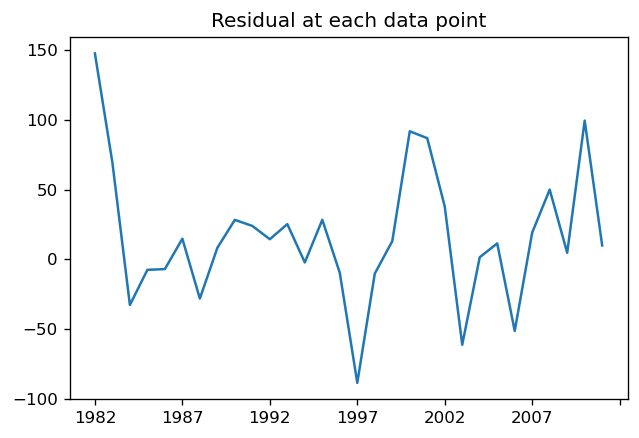

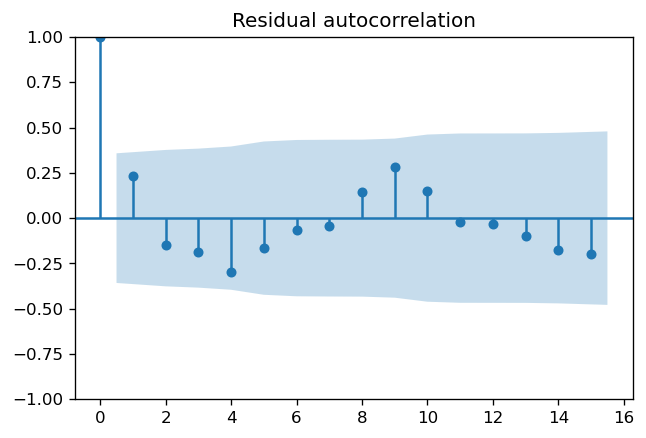

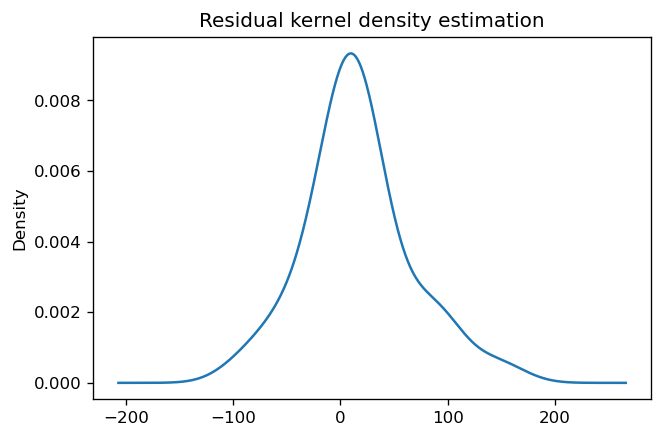

                0
count   30.000000
mean    16.266874
std     48.825874
min    -88.646861
25%     -7.398261
50%     12.233217
75%     28.372690
max    147.800000
p value is  0.1761475398555586
null hypothesis: residuals come from a normal distribution
The null hypothesis cannot be rejected


In [13]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    


##### First, we get a line plot of the residual errors, suggesting that the trend is likely already taken care of in the ARIMA model. Next, we get a density plot of the residual error values. Finally distribution of the residual errors is displayed.

#### After implement formal autocorrelation test, the residual series shows stationary.

#### for the normality test, p value is 0.1761475398555586. But it can be rejected if alpha=18% and accept at 10% significance level.

In [14]:
#a formal autocorrelation test (e.g., Ljung–Box test).¶
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

Ljung–Box:
    lb_stat  lb_pvalue
1  1.758331   0.184833
2  2.495772   0.287111
3  3.757632   0.288853
4  7.028119   0.134410
5  8.093675   0.151148
6  8.257999   0.219804


#### for Ljung–Box, P-value>0.05,we accept the null hypothesis.Thus the residual is independent and  is a white niose series.

In [15]:
#including MAE, RSME, PACF, ACF
from sklearn.metrics import mean_absolute_error, mean_squared_error

fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()


fc_series = pd.Series(fc['mean'].values, index=range(N,len(series)))
insample= model_fit.predict(start=1,end=N,dynamic=False,typ='levels')

print('ARIMA model test-set MAE', mean_absolute_error(task1[N:],fc_series))
print('ARIMA model train-set MAE', mean_absolute_error(task1[:N],insample))


ARIMA model test-set MAE 54.74116625805378
ARIMA model train-set MAE 52.0300756976076


In [16]:
#RSME
print('ARIMA model test-set RMSE', np.sqrt(mean_squared_error(task1[N:],fc_series)))
print('ARIMA model train-set RMSE', np.sqrt(mean_squared_error(task1[:N],insample)))


ARIMA model test-set RMSE 59.47730524865058
ARIMA model train-set RMSE 55.53298018309429


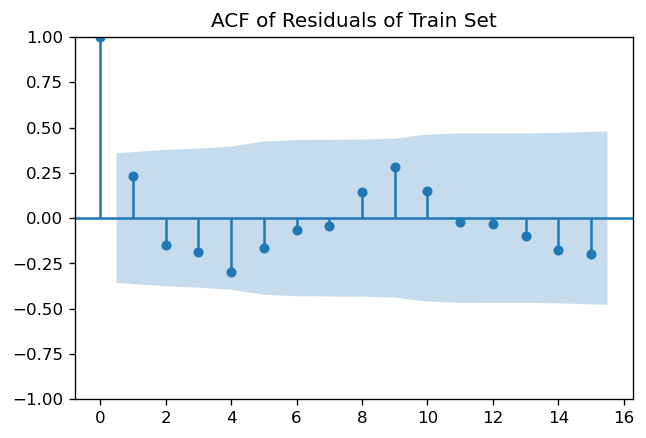

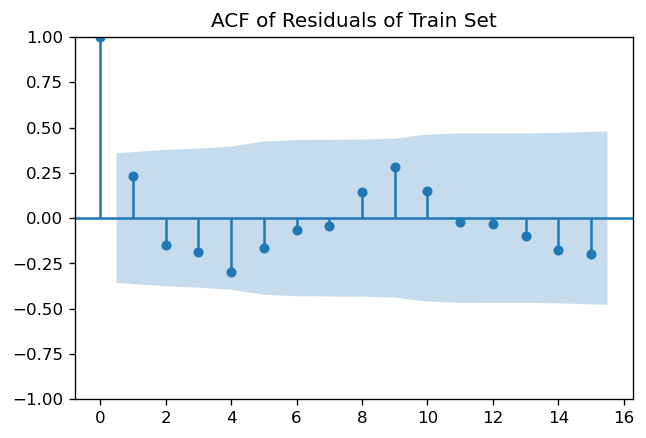

In [17]:
#PACF, ACF
# perform residual diagnostics for the training set
plot_acf(residuals,title='ACF of Residuals of Train Set')

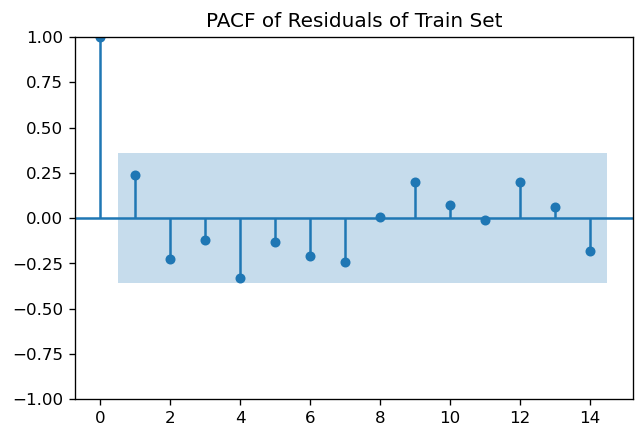

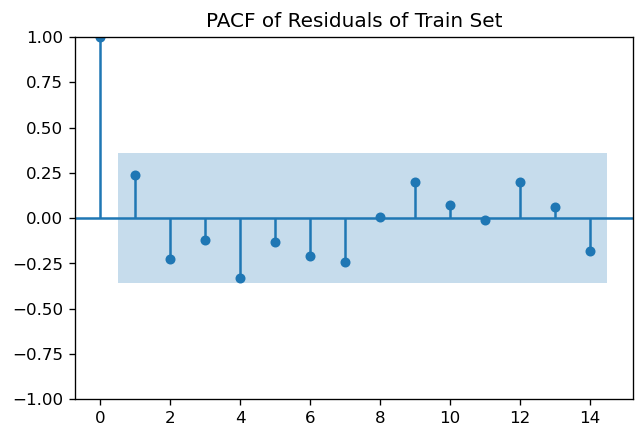

In [18]:
plot_pacf(residuals, title='PACF of Residuals of Train Set',lags=14)

#### After implement formal autocorrelation test, the residual series shows stationary.

#### After implement formal partial autocorrelation test, the residual series shows well captured. If the PACF of the residuals shows significant spikes at lags beyond the order of the ARIMA model, it indicates that there is still some information left in the data that the model hasn't captured.

## Task 5 
### Plot the original series, in-sample prediction results, and out-of-sample prediction results. Please label them properly.


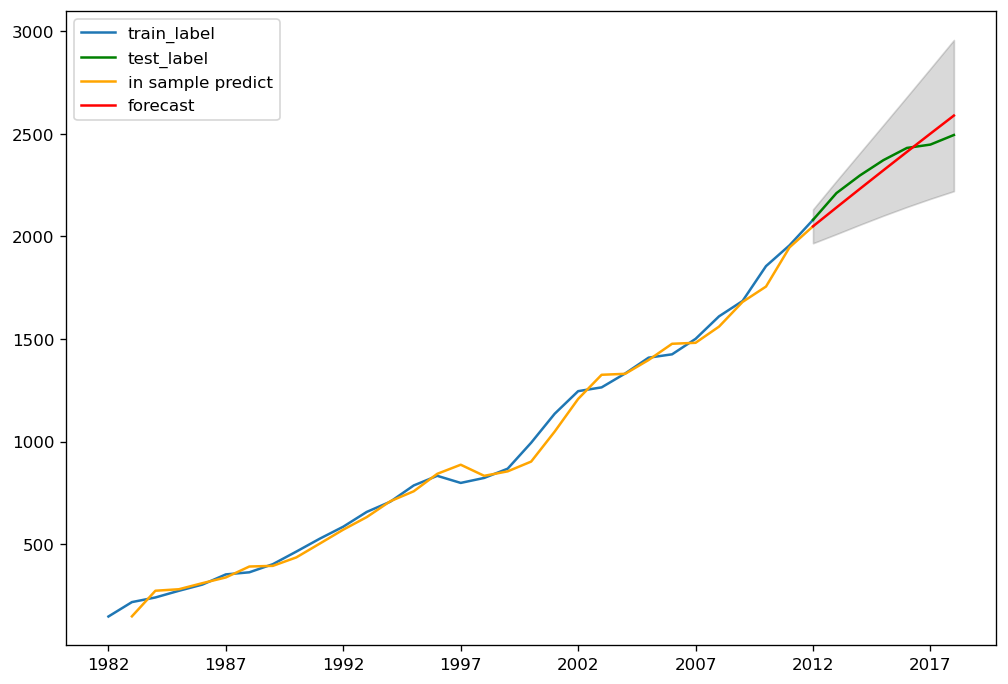

In [19]:
# Forecast


fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()



fc_series = pd.Series(fc['mean'].values, index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower.values, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper.values, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,7)})
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.plot(task1.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(task1.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(task1.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
         color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(task1.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

# Homework 2: Using ARIMA model to predict a one-direction random walk.
### Task 1, generate a one-dimensional random walk which starts at 0 and makes a step up or down with the equal probability. Simulate 1000 steps and use the random seed 1234. Visualize the result.


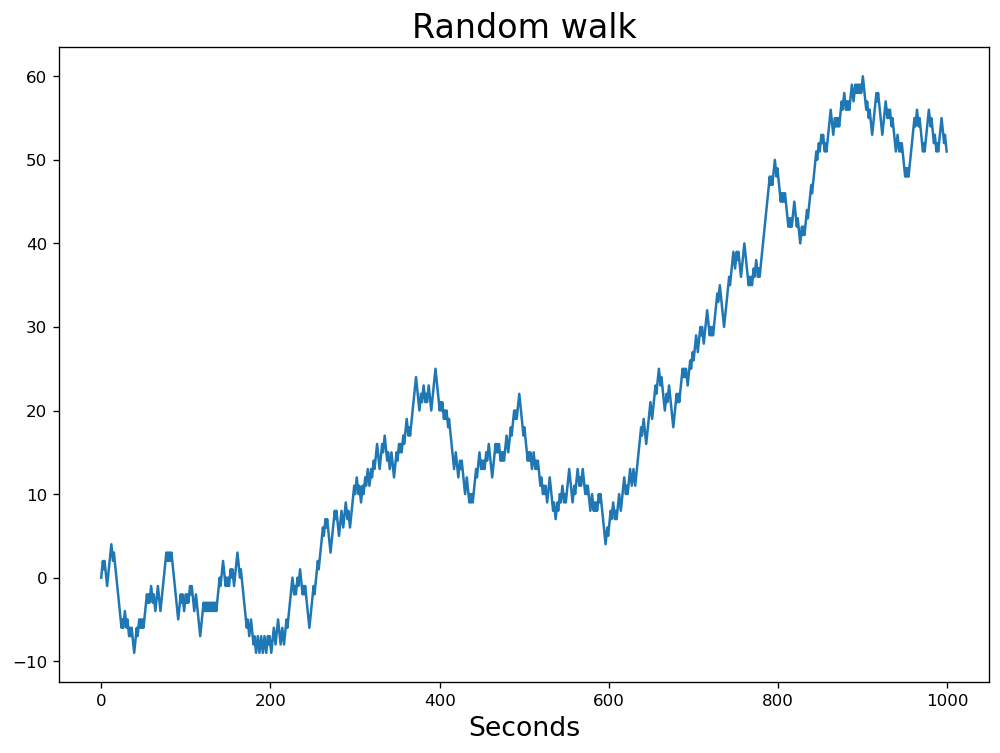

In [20]:
#set the seed
np.random.seed(1234)
pos = 0 
walk = [pos] 
nsteps = 1000 
#makes a step up or down with the equal probability
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 
    pos += step
    walk.append(pos)

    
plt.plot(walk[0:1000])
plt.title('Random walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

#plt.xlabel('steps')
plt.show()

### Task 2, difference the series to stationary, and report the adfuller test results, $\alpha=0.05$

In [21]:
series1 = pd.DataFrame(walk)

print('raw series')
result = adfuller(series1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('1st order differencing')
result = adfuller(series1.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# second order differencing

print('2st order differencing')
result = adfuller(series1.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


raw series
ADF Statistic: -0.350132
p-value: 0.918098
1st order differencing
ADF Statistic: -31.746941
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568
2st order differencing
ADF Statistic: -14.557797
p-value: 0.000000
	1%: -3.437
	5%: -2.864
	10%: -2.568


The p value is smaller than 5% when after first differencing process. So it is stationary at 1st order differencing

### Task 3, PACF and ACF plot of the diferenced time-series.

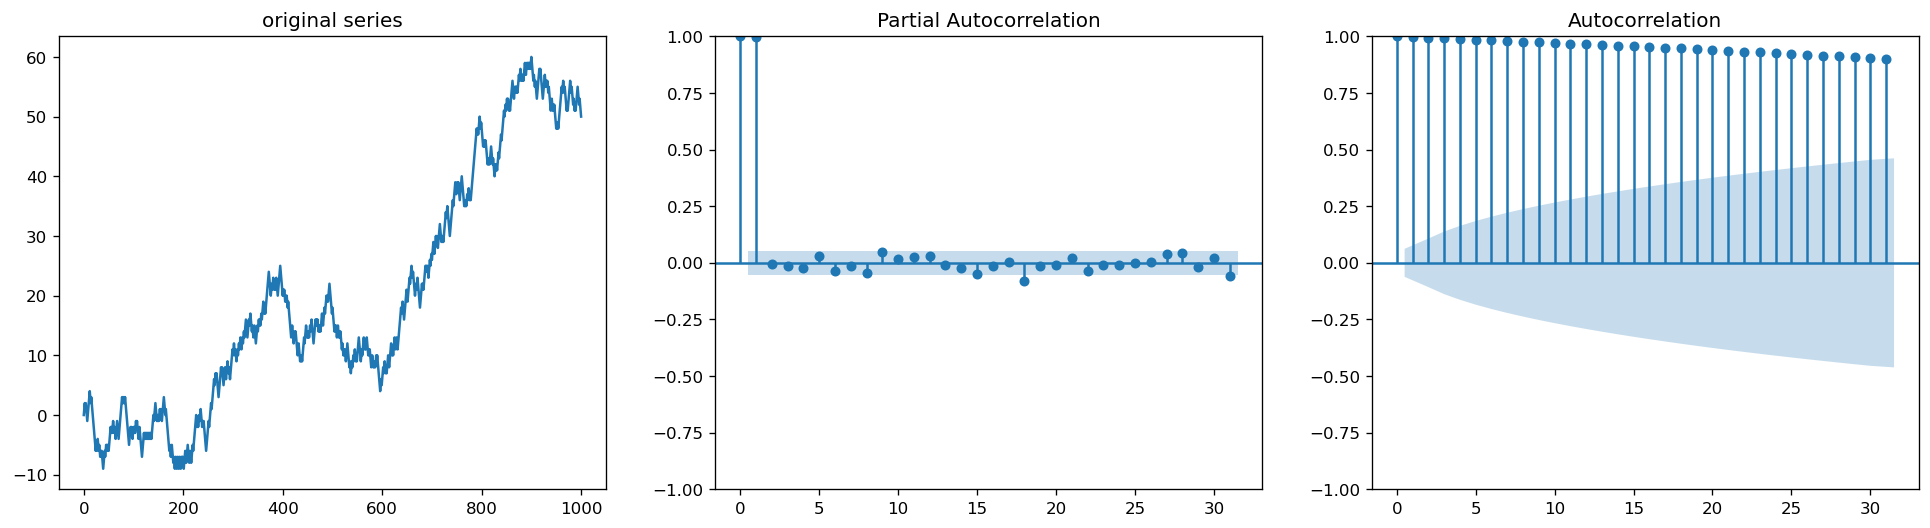

In [22]:
# for original series
#plt.rcParams.update({'figure.figsize':(10,20), 'figure.dpi':120})

#determine appropriate number of AR
fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes[0].plot(series1)
axes[0].set_title('original series')
plot_pacf(series1.dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations
plot_acf(series1.dropna(), ax=axes[2])
plt.show()


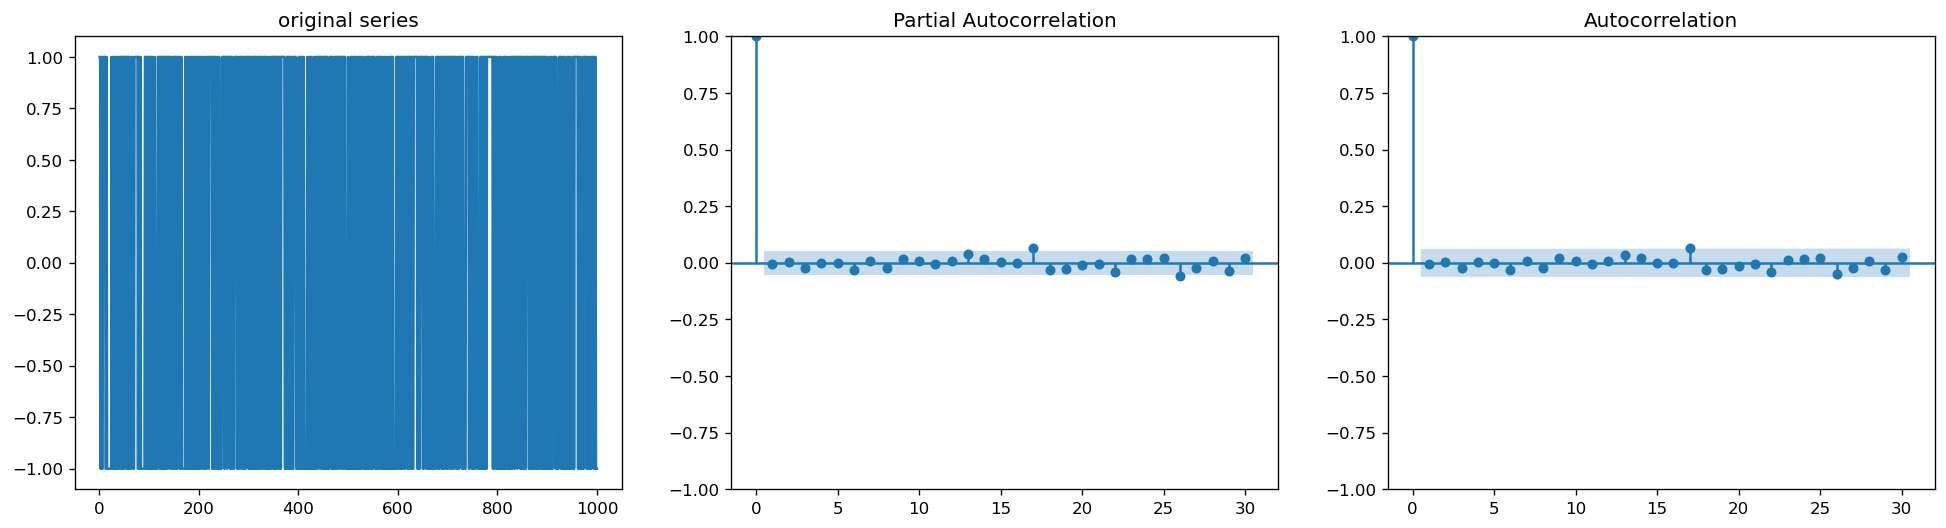

In [23]:
# for fisrt 1st Order Differencing

#determine appropriate number of AR
fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes[0].plot(series1.diff())
axes[0].set_title('original series')
plot_pacf(series1.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations
plot_acf(series1.diff().dropna(), ax=axes[2])
plt.show()


In [24]:
#Ljung–Box test
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(series1.diff().dropna()))

Ljung–Box:
     lb_stat  lb_pvalue
1   0.030521   0.861314
2   0.042846   0.978805
3   0.514427   0.915711
4   0.516672   0.971858
5   0.516823   0.991494
6   1.601123   0.952497
7   1.706271   0.974299
8   2.230290   0.973125
9   2.652249   0.976505
10  2.709086   0.987466


### Task 4, When analyzing the PACF and ACF results of the random walk, what pattern shows that ARIMA won't be a useful model for this time-series? Write down your statement.

From the plots，both the PACF and ACF plots will show strong and significant correlations at all lags,indicating that the time series is highly dependent on its past values. 

This means that any attempt to model the random walk with an ARIMA model is unlikely to be useful.In the case of a random walk, there is no clear pattern or trend in the data, and the behavior of the time series at any point in time is completely unpredictable based on its past values. Therefore, an ARIMA model is not a suitable approach for modeling a random walk time series.